**Name:** Subhrajit Mishra <br>
**Roll No.:** 201006 

Given: 𝜋(𝑎|𝑠, 𝜽) = softmax(𝜽 ⋅ 𝑠) = [exp {𝜽<sup>T</sup><sub>1</sub> 𝑠}` `exp {𝜽<sup>T</sup><sub>2</sub> 𝑠}]<sup>T</sup>/ exp {𝜽<sup>T</sup><sub>1</sub> 𝑠} + exp {𝜽<sup>T</sup><sub>2</sub> 𝑠}

In [4]:
import gymnasium as gym
env = gym.make('CartPole-v1')
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

Q - Write the expression for the gradient ∇ ln 𝜋(𝐴𝑡|𝑆𝑡, 𝜽) for the given policy. <br>
<br>
Ans: It is a 2x2 matrix, with column 1 referring to differentiating both the terms with respect to 𝜽<sub>1</sub>, and column 2 wrt 𝜽<sub>2</sub>.<br>
Column 1: 
$$\nabla_\theta \log \pi (A_t=0 \mid s_t;\theta)=\begin{bmatrix}𝑆_𝑡 - \frac{exp ({{𝜽_1}^T.𝑆_𝑡} ). 𝑆_t}{exp({{𝜽_1}^T.𝑆_𝑡} ) +exp ({{𝜽_2}^T.𝑆_𝑡} )}\\- \frac{exp ({{𝜽_2}^T.𝑆_𝑡} ). 𝑆_t}{exp({{𝜽_1}^T.𝑆_𝑡} ) +exp ({{𝜽_2}^T.𝑆_𝑡} )}\end{bmatrix}$$
Column 2: 
$$\nabla_\theta \log \pi (A_t=1 \mid s_t;\theta)=\begin{bmatrix}- \frac{exp ({{𝜽_1}^T.𝑆_𝑡} ). 𝑆_t}{exp({{𝜽_1}^T.𝑆_𝑡} ) +exp ({{𝜽_2}^T.𝑆_𝑡} )}\\𝑆_𝑡 - \frac{exp ({{𝜽_2}^T.𝑆_𝑡} ). 𝑆_t}{exp({{𝜽_1}^T.𝑆_𝑡} ) +exp ({{𝜽_2}^T.𝑆_𝑡} )}\end{bmatrix}$$


In [21]:
class PolicyNetwork:
    def __init__(self, state_size, action_size):
        # self.state_size = state_size
        # self.action_size = action_size
        self.weights = np.random.rand(state_size, action_size)

    def forward(self, state):
        logits = state@ self.weights
        for i in range(len(logits)):
            if logits[i]>=100:
                logits[i]=100
        pro = np.exp(logits) / np.sum(np.exp(logits))
        return pro

    def act(self, state):
        probs = self.forward(state)
        action = np.random.choice([0,1], p=probs)
        return action, probs


# Define the REINFORCE function
def reinforce(policy_network, n_episodes=1000, max_t=1000, gamma=1, print_every=100):
    scores_deque = deque(maxlen=100)
    # plotter_reward = []
    scores = []

    for i_episode in range(1, n_episodes+1):
        rewards = []
        actions = []
        states = []

        state = env.reset()[0]
        # print("env.reset_state: ", state)
        for t in range(max_t):
            # print("state", state)
            action, probs = policy_network.act(state)
            states.append(state)
            actions.append(action)
            result = env.step(action)
            state, reward, done, trunc = result[:4]
            # print("env.step_state", state)
            rewards.append(reward)
            if done or trunc:
                break
        
        T = len(rewards)
        for t in range(T):
            G=0
            for k in range(t+1, T):
                G+= gamma**(k-t-1)*rewards[k-1]
            # discounts = [gamma**i for i in range(len(rewards)+1)]
            # G = sum(discounts)
            logits = states[t]@ policy_network.weights
            for i in range(len(logits)):
                if logits[i]>=100:
                    logits[i]=100
            # Compute softmax probabilities
            # pro = np.exp(shifted_logits) / np.sum(np.exp(shifted_logits))
                    
            pro = np.exp(logits) / np.sum(np.exp(logits))
            # grad1 = (1-saved_probs[t][actions[t]])*(gamma**t)
            grad=0
            if actions[t]==0:
                grad=(1-pro[0])*(gamma**t)*0.01* G*np.vstack((states[t],-states[t])).T
            else:
                grad=(1-pro[1])*(gamma**t)*0.01* G*np.vstack((-states[t],states[t])).T
            policy_network.weights+=grad
            # print("Weights: ", PolicyNetwork.weights)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    plt.plot(scores)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards over 1000 Episodes')
    plt.show()
    return scores

Episode 100	Average Score: 136.65
Episode 200	Average Score: 164.64
Episode 300	Average Score: 130.24
Episode 400	Average Score: 164.22
Episode 500	Average Score: 440.31
Episode 600	Average Score: 482.99
Episode 700	Average Score: 500.00
Episode 800	Average Score: 500.00
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 500.00


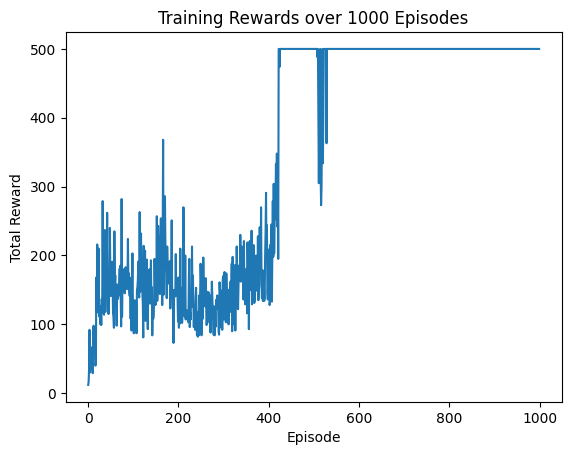

In [22]:
state_size = 4 
action_size = 2
policy_net = PolicyNetwork(state_size, action_size)
scores = reinforce(policy_net)

In [7]:
rewards=[]
for i_episode in range(1, 6):
    
    state = env.reset()[0]
    # print("env.reset_state: ", state)
    r=0
    while True:
        # print("state", state)
        action, probs = policy_net.act(state)
        result = env.step(action)
        state, reward, done, trunc = result[:4]
        # print("env.step_state", state)
        r=r+reward
        if done or trunc:
            break
    rewards.append(r)
print(np.mean(np.array(rewards)))


28.2


**Using Baseline**

In [14]:
class PolicyNetwork1:
    def __init__(self, state_size, action_size):
        self.weights = np.random.rand(state_size, action_size)
        self.weights2 = np.random.rand(state_size)
        # print(self.weights2)

    def forward(self, state):
        logits = state@ self.weights
        for i in range(len(logits)):
            if logits[i]>=100:
                logits[i]=100
        pro = np.exp(logits) / np.sum(np.exp(logits))
        return pro

    def act(self, state):
        probs = self.forward(state)
        action = np.random.choice(len(probs), p=probs)
        return action, probs

def reinforce_baseline(policy_network, n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        rewards = []
        actions = []
        states = []

        state = env.reset()[0]
        for t in range(max_t):
            action, probs = policy_network.act(state)
            states.append(state)
            actions.append(action)
            result = env.step(action)
            state, reward, done, trun = result[:4]
            rewards.append(reward)
            if done or trun:
                break
        
        T = len(rewards)
        for t in range(T):
            G=0
            for k in range(t+1, T):
                G+= gamma**(k-t-1)*rewards[k-1]
            
            v_hat = np.dot(states[t], policy_network.weights2)
            delta = G - v_hat
            policy_network.weights2 += 1e-3 * delta * states[t]
            logits = states[t]@ policy_network.weights
            for i in range(len(logits)):
                if logits[i]>=100:
                    logits[i]=100
            # Compute softmax probabilities
            # pro = np.exp(shifted_logits) / np.sum(np.exp(shifted_logits))
                    
            pro = np.exp(logits) / np.sum(np.exp(logits))
            # grad1 = (1-saved_probs[t][actions[t]])*(gamma**t)
            grad=0
            if actions[t]==0:
                grad=(1-pro[0])*(gamma**t)*0.01*delta*np.vstack((states[t],-states[t])).T
            else:
                grad=(1-pro[1])*(gamma**t)*0.01*delta*np.vstack((-states[t],states[t])).T
            # policy_network.weights += 1e-2 * delta * np.outer(states[t], gradient)
            policy_network.weights += grad
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    plt.plot(scores)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards over 1000 Episodes')
    plt.show()
    return scores

Episode 100	Average Score: 148.34
Episode 200	Average Score: 178.89
Episode 300	Average Score: 235.10
Episode 400	Average Score: 185.35
Episode 500	Average Score: 441.66
Episode 600	Average Score: 479.73
Episode 700	Average Score: 460.06
Episode 800	Average Score: 309.91
Episode 900	Average Score: 388.25
Episode 1000	Average Score: 463.08


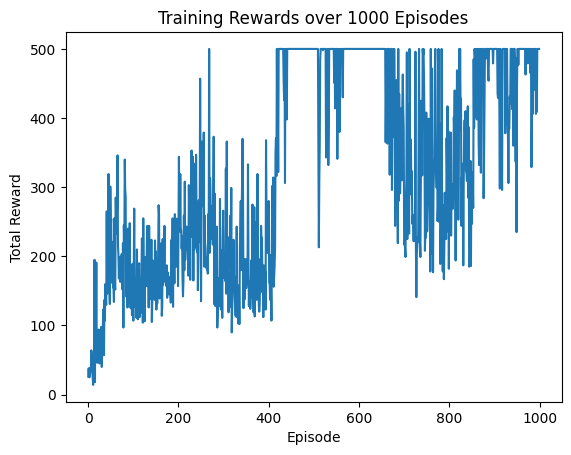

In [15]:
state_size = 4
action_size = 2
policy_net1 = PolicyNetwork1(state_size, action_size)
scores = reinforce_baseline(policy_net1)

In [ ]:
rewards=[]
for i_episode in range(1, 6):
    
    state = env.reset()[0]
    # print("env.reset_state: ", state)
    r=0
    while True:
        # print("state", state)
        action, probs = policy_net1.act(state)
        result = env.step(action)
        state, reward, done, trunc = result[:4]
        # print("env.step_state", state)
        r=r+reward
        if done or trunc:
            break
    rewards.append(r)
print(np.mean(np.array(rewards)))

500.0


Episode 100	Average Score: 86.94
Episode 200	Average Score: 148.94
Episode 300	Average Score: 165.22
Episode 400	Average Score: 149.33
Episode 500	Average Score: 192.21
Episode 600	Average Score: 246.37
Episode 700	Average Score: 426.37
Episode 800	Average Score: 499.70
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 500.00


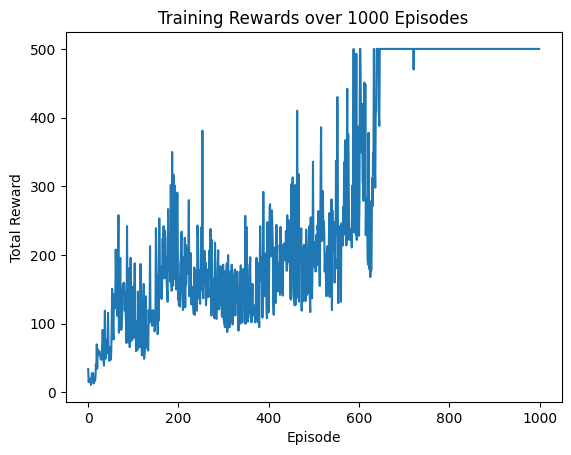

Episode 100	Average Score: 155.05
Episode 200	Average Score: 470.53
Episode 300	Average Score: 470.92
Episode 400	Average Score: 497.35
Episode 500	Average Score: 485.16
Episode 600	Average Score: 479.04
Episode 700	Average Score: 487.94
Episode 800	Average Score: 418.93
Episode 900	Average Score: 454.10
Episode 1000	Average Score: 355.15


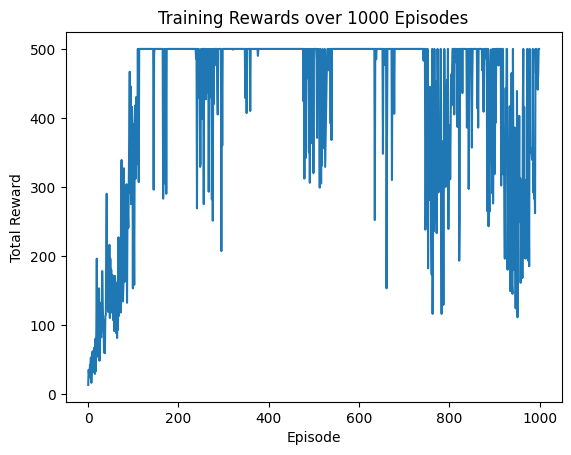

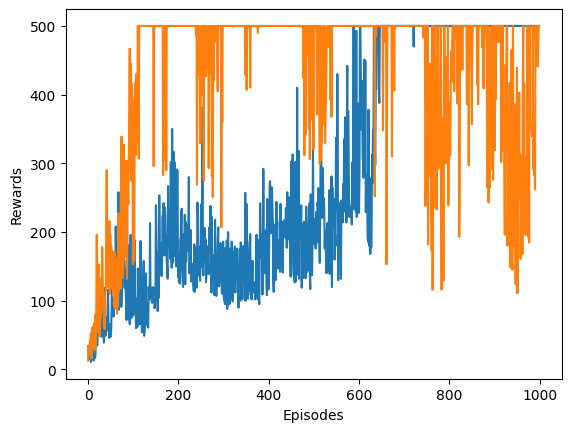

In [25]:
policy_net = PolicyNetwork(state_size, action_size)
scores = reinforce(policy_net)
policy_net1 = PolicyNetwork1(state_size, action_size)
scores2 = reinforce_baseline(policy_net1)
plt.plot(scores)
plt.plot(scores2)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()